In [1]:
import pandas as pd
import numpy as np
import random
from pprint import pprint
import sys
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches

from scipy.stats import entropy
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import FuncFormatter

from scipy.stats import sem

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 1000)

COL_WIDTH=250
CMAP = 'seismic_r'
_CMAP = 'viridis'
pd.options.display.max_colwidth = COL_WIDTH

EASY_THRESH = 0.75
MEDIUM_THRESH = 0.5
HARD_THRESH = 0.25
IMPOSSIBLE_THRESH = 0.0
ALPHA = 0.6

SEEDS = [42, 43, 44, 45, 46]
# BASE_PATH = '/Users/ardsnijders/Documents/GitHub/Lisa/active_learning/results/ard_output_dir_results/datamaps/test/datamap_test_subepoch_inference_elke_0.5_epochs/roberta-large/random/SEED/confidences.pickle'
BASE_PATH = '/Users/ardsnijders/Documents/GitHub/Lisa/active_learning/results/ard_output_dir_results/datamap/test/datamap_op_test_set_subepoch_inference_elke_0.5_epochs_max_4_epochs/random/SEED/datamap.pickle'
STRATEGY_PATH = "/Users/ardsnijders/Documents/GitHub/Lisa/active_learning/results/ard_output_dir_results/acquisition_IDs/array/OOD_MNLI_active_learning_array_remove_bottom_025_poging_4/roberta-large/STRATEGY/SEED/acquisition_ids.csv"


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

# Loading pickled confidences

In [2]:
def load_confidences(path, predictions=False, exclude=1):

    df = pd.read_pickle(path)
    sample_ids = list(df.keys())

    cartography_dict = {}
    prediction_dict = {}

    for sample_id in sample_ids:

        times_correct = []
        confidences = []

        outputs = df[sample_id]
        outputs = outputs[exclude:] # don't count the first 0.5 epoch!

        for output in outputs:

            # extract values from output tuple
            prediction = output[0]
            label = output[1]

            # obtain GT confidence, determine correctness of prediction
            confidence = prediction[label]
            correct = 1 if prediction.index(max(prediction)) == label else 0

            # track confidence and correctness
            confidences.append(confidence)
            times_correct.append(correct)


        cartography_dict[sample_id] = {'confidence': np.mean(confidences),
                                      'variability': np.std(confidences),
                                      'correctness': np.mean(times_correct)}

        prediction_dict[sample_id] = {'prediction': outputs[-1][0]}

    confidences = [cartography_dict[key]['confidence'] for key in list(cartography_dict.keys())]
    variability = [cartography_dict[key]['variability'] for key in list(cartography_dict.keys())]
    correctness = [cartography_dict[key]['correctness'] for key in list(cartography_dict.keys())]

    df = pd.DataFrame(list(zip(sample_ids, confidences, variability, correctness)), columns=['id', 'mean_conf', 'variability', 'correctness'])
    
    if predictions == False:
        return df
    else:
        return df, prediction_dict

# Code to read datasets

In [3]:
def read_dataset(input_dir, dataset_id, split, seed, wanli_id):
    """
    This function takes a dataset id and reads the corresponding .json split in an appropriate Pandas DataFrame
    :param wanli_id: id key for wanli json file (pairID for metrics, id for non metric stuff)
    :param seed:
    :param input_dir:
    :param dataset_id: str indicating which dataset should be read
    :param split: str indicating which split should be read
    :return: DataFrame with examples (Premise, Hypothesis, Label, ID)
    """
    # anli_rounds = ['ANLI_R1', 'ANLI_R2', 'ANLI_R3']
    anli_rounds = ['ANLI_R2', 'ANLI_R3']

    def replace_labels(label):
        label_conversions = {'e': 'entailment',
                             'c': 'contradiction',
                             'n': 'neutral'}

        return label_conversions[label]

    if dataset_id == 'SNLI':

        # TODO only consider snli with gold labels?
        data_path = '{}/snli_1.0/snli_1.0_{}.jsonl'.format(input_dir, split)
        dataset = pd.read_json(data_path, lines=True)
        dataset = dataset[['sentence1', 'sentence2', 'gold_label', 'pairID']]
        dataset['dataset'] = 'SNLI'
        dataset = dataset.drop(dataset[dataset.gold_label.str.contains('-')].index)  # drop examples with no gold label

    # load separate ANLI rounds
    elif dataset_id in anli_rounds:

        data_round = dataset_id[-2:]  # extract the 'R#' substring from the provided ID
        data_path = '{}/anli_v1.0/{}/{}.jsonl'.format(input_dir, data_round, split)
        dataset = pd.read_json(data_path, lines=True)
        dataset = dataset[['context', 'hypothesis', 'label', 'uid']]  # get rid of unnecessary columns
        dataset['label'] = dataset['label'].apply(replace_labels)  # ensures consistently named labels
        dataset['dataset'] = 'ANLI_{}'.format(data_round)
        #
        # print('Dataframe for {} - {}'.format(dataset_id, split), flush=True)

    # compile all ANLI rounds
    elif dataset_id == 'ANLI':

        dataset_list = []
        for data_round in anli_rounds:
            data_round = data_round[-2:]
            data_path = '{}/anli_v1.0/{}/{}.jsonl'.format(input_dir, data_round, split)
            dataset = pd.read_json(data_path, lines=True)
            dataset = dataset[['context', 'hypothesis', 'label', 'uid']]  # get rid of unnecessary columns
            dataset['label'] = dataset['label'].apply(replace_labels)  # ensures consistently named labels
            dataset['dataset'] = 'ANLI'
            dataset_list.append(dataset)
        dataset = pd.concat(dataset_list, axis=0)

    # Load MNLI
    elif dataset_id == 'MNLI':

        if split == 'train':
            data_path = '{}/multinli_1.0/multinli_1.0_{}.jsonl'.format(input_dir, split)
        elif split == 'dev' or split == 'test':
            data_path = '{}/multinli_1.0/multinli_1.0_dev_matched.jsonl'.format(input_dir)

        dataset = pd.read_json(data_path, lines=True)
        dataset = dataset[['sentence1', 'sentence2', 'gold_label', 'pairID']]
        dataset['dataset'] = 'MNLI'
        dataset = dataset.drop(dataset[dataset.gold_label.str.contains('-')].index)

        # split dev into dev and test set
        if split == 'dev':
            dataset = dataset.sample(frac=1,  # reshuffle all rows in the dataframe prior to split
                                     random_state=seed)  # seed is fixed such that dev and test set are always the same
            dataset = dataset[:int((len(dataset)/2))]

        elif split == 'test':
            dataset = dataset.sample(frac=1,
                                     random_state=seed)
            dataset = dataset[int((len(dataset)/2)):]

    # Load WANLI
    elif dataset_id == 'WANLI':

        if split == 'train':
            data_path = '{}/wanli/train.jsonl'.format(input_dir)
        elif split == 'dev' or split == 'test':
            data_path = '{}/wanli/test.jsonl'.format(input_dir)

        dataset = pd.read_json(data_path, lines=True)
        dataset = dataset[['premise', 'hypothesis', 'gold', wanli_id]]
        dataset['dataset'] = 'WANLI'
        dataset = dataset.drop(dataset[dataset.gold.str.contains('-')].index)

        # split dev into dev and test set
        if split == 'dev':
            dataset = dataset.sample(frac=1,  # reshuffle all rows in the dataframe prior to split
                                     random_state=seed)  # seed is fixed such that dev and test set are always the same
            dataset = dataset[:int((len(dataset) / 2))]

        elif split == 'test':
            dataset = dataset.sample(frac=1,
                                     random_state=seed)
            dataset = dataset[int((len(dataset) / 2)):]

    else:
        raise KeyError('No dataset found for "{}"'.format(dataset_id))

    # ensure consistent headers per dataset DataFrame
    dataset.columns = ['Premise', 'Hypothesis', 'Label', 'ID', 'Dataset']

    dataset['ID'] = dataset['ID'].astype('string')

    return dataset

In [30]:
INPUT_DIR='/Users/ardsnijders/Documents/GitHub/Lisa/active_learning/resources/ard_data'
SPLIT='test'
WANLI_ID='pairID'

def read_source(dataset_id):
    dataset = read_dataset(input_dir=INPUT_DIR, 
                 dataset_id=dataset_id, 
                 split='train', 
                 seed=None, 
                 wanli_id=WANLI_ID)
    return dataset

# Loading all datasets into their own DataFrame

In [31]:
# mnli = read_source('MNLI')
# snli = read_source('SNLI')
anli = read_source('ANLI')
# wanli = read_source('WANLI')

In [35]:
anli.Label.value_counts(normalize=True)

neutral          0.423091
entailment       0.320315
contradiction    0.256594
Name: Label, dtype: float64

In [36]:
for value in list(anli.Label.value_counts(normalize=True)):
    
    print(value*len(anli))

61736.99999999999
46740.0
37442.0


In [29]:
len(wanli)

2500

In [28]:
print(wanli.Label.value_counts(normalize=True))

for value in list(wanli.Label.value_counts(normalize=True)):
    
    print(value*len(wanli))

neutral          0.4808
entailment       0.3676
contradiction    0.1516
Name: Label, dtype: float64
1202.0
919.0
379.00000000000006


# Code for Generating Datamaps for Different Sources / Strategies

In [23]:
def generate_df(dataframe):
    X = dataframe['variability'].tolist()
    Y = dataframe['mean_conf'].tolist()
    colors = dataframe['correctness'].tolist()

    plt.figure(figsize=(30, 10))
    plt.scatter(x=X, y=Y, c=colors, alpha=1, cmap=mpl.cm.get_cmap(CMAP))
    plt.xlim(0,0.5)
    plt.ylim(0,1)
    plt.xlabel('Variability')
    plt.ylabel('Confidence')
    plt.legend()
    plt.show()
    
def generate_source_map(base_df, source_df):

    ids = source_df.ID

    source_df = base_df[base_df.id.astype('string').isin(ids)]
    
    print('num of source in base: {}'.format(len(source_df)))
    
    generate_df(source_df)
    
def datamap_subset(base_df, source_df, name=None):
    
    source_ids = source_df.ID
    
    subset_df = base_df[base_df.id.astype('string').isin(source_ids)]

    if name is not None:
        subset_df['Name'] = name
    else:
        subset_df['Name'] = source_df.Dataset.tolist()[0]
    
    return subset_df

def datamap_subset_multi(base_path, source_df, name=None):
    
    list_of_maps = []
    
    source_ids = source_df.ID
    
    for seed in SEEDS:
        
        _base_path = base_path.replace('SEED', str(seed))
        
        base_df = load_confidences(_base_path, predictions=False)

        subset_df = base_df[base_df.id.astype('string').isin(source_ids)]

        if name is not None:
            subset_df['Name'] = name
        else:
            subset_df['Name'] = source_df.Dataset.tolist()[0]
            
        list_of_maps.append(subset_df)
    
    return list_of_maps

def generate_dfs_2(dataframes, markers=None, size=40, n_bins=10, font_size=20):
    
    plt.rcParams.update({'font.size': font_size})
    
    def generate_hist(axis, data, name, color, colormap, n_bins=10):
        
        cmap = False
        if color == 'cmap':
            cmap = True
            color = 'green'
        
        n, bins, patches = axis.hist(data, 
                                     n_bins, 
                                     weights=np.ones(len(data)) / len(data), 
                                     density=False, 
                                     color=color)

        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        
        if cmap:
        
            # scale values to interval [0,1]
            col = bin_centers - min(bin_centers)
            col /= max(col)

            for c, p in zip(col, patches):
                plt.setp(p, 'facecolor', colormap(c))

        axis.set_xlabel(name)
        axis.set_ylim(0,1)

        axis.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
    
    # creating grid for subplots
    fig = plt.figure()
    fig.set_figheight(size)
    fig.set_figwidth(size)

    ax1 = plt.subplot2grid(shape=(4, 4), loc=(0, 0), colspan=3, rowspan=4)
    ax2 = plt.subplot2grid(shape=(4, 4), loc=(0, 3), rowspan=1)
    ax3 = plt.subplot2grid(shape=(4, 4), loc=(1, 3), colspan=1)
    ax4 = plt.subplot2grid(shape=(4, 4), loc=(2, 3), rowspan=1)
    ax5 = plt.subplot2grid(shape=(4, 4), loc=(3, 3), rowspan=1)
    
    for dataframe in dataframes:

        if markers is not None:

            for dataset, marker in zip(['SNLI', 'ANLI', 'WANLI', 'MNLI'], ['s', 'x', 'o', 'v']):


                sub_frame = dataframe[dataframe['Dataset'] == dataset]
                X = sub_frame['variability'].tolist()
                Y = sub_frame['mean_conf'].tolist()
                colors = sub_frame['correctness'].tolist()
                ax1.scatter(x=X, y=Y, c=colors, alpha=1, marker=marker, cmap=mpl.cm.get_cmap(CMAP), label=dataset, s=size)

        else:


            X = dataframe['variability'].tolist()
            Y = dataframe['mean_conf'].tolist()
            colors = dataframe['correctness'].tolist()

            ax1.scatter(x=X, y=Y, c=colors, alpha=1, cmap=mpl.cm.get_cmap(CMAP), s=size)

        
        name = dataframe.Name.tolist()[0].upper()
        ax1.set_title('Dataset Map for ' + name + ' Test Data')
        ax1.set_xlabel('Variability')
        ax1.set_ylabel('Confidence')

        if markers:
            ax1.legend(loc='upper right', prop={'size': 30})
            ax1.legend(markerscale=4)
            
        break # terminate loop for datamap after first seed since only one seed can be plotted
    
    
    easy = []
    medium = []
    hard = []
    impossible = []
    X = []
    Y = []
    correctness = []
    for dataframe in dataframes:
    
        X.extend( dataframe['variability'].tolist() )
        Y.extend( dataframe['mean_conf'].tolist() )
        correctness.extend( dataframe['correctness'].tolist() )

        easy.append( len(dataframe[dataframe['mean_conf'] > EASY_THRESH])  )
        medium.append( len(dataframe[(dataframe['mean_conf'] > MEDIUM_THRESH) & (dataframe['mean_conf'] < EASY_THRESH)])  )
        hard.append( len(dataframe[(dataframe['mean_conf'] > HARD_THRESH) & (dataframe['mean_conf'] < MEDIUM_THRESH)])   )
        impossible.append( len(dataframe[(dataframe['mean_conf'] > IMPOSSIBLE_THRESH) & (dataframe['mean_conf'] < HARD_THRESH)])  )
    
    # take the mean over difficulty brackets
    # TODO: generate std bars?
    def mean_and_std_e(array):
        
        return np.mean(array), np.std(array)
    
    easy, std_easy = mean_and_std_e(easy)
    medium, std_medium = mean_and_std_e(medium)
    hard, std_hard = mean_and_std_e(hard)
    impossible, std_impossible = mean_and_std_e(impossible)
    
#     std_easy, std_medium, std_hard, std_impossible = 200,30,400,20
    
    # LEARNABILITY      
    width = 1
    cmap = mpl.cm.get_cmap(CMAP)
    
    categories = ['Easy', 'Med', 'Hard', 'Imp.']
    x_pos = [0,1,2,3]
    means = [easy, medium, hard, impossible]
    
    
    y_err = [std_easy, std_medium, std_hard, std_impossible]
    
    normed_means = [mean / sum(means) for mean in means]
    y_err = [std / sum(means) for std in y_err]
    
    colors = [cmap(value) for value in [0.85, 0.65, 0.35, 0.125]]
    
    labels = [('[p > {}]'.format(thresh, color=cmap(value), alpha=ALPHA)) for thresh, value in zip([EASY_THRESH, MEDIUM_THRESH, HARD_THRESH, IMPOSSIBLE_THRESH],[0.85, 0.65, 0.35, 0.125])]
    ax2.bar(x_pos, normed_means, yerr=y_err, width=1, color=colors, capsize=10, alpha=ALPHA)

    thresholds = [EASY_THRESH, MEDIUM_THRESH, HARD_THRESH, IMPOSSIBLE_THRESH]
    patches = [mpatches.Patch(color=value, label='[p > {}]'.format(thresh), alpha=ALPHA) for thresh, value in zip(thresholds, colors)]
    
    ax2.legend(handles=patches, loc='upper right')
    
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(categories)
    ax2.set_ylim(0,1)
    
#     ylabels = ['{}'.format(round(x,1)) + 'K' for x in ax2.get_yticks()[::1]/1000]
    ylabels = ['{}%'.format(int(x))  for x in ax2.get_yticks()[::1]*100]
    ax2.set_yticklabels(ylabels)    
    ax2.set_xlabel('Learnability')
#     ax2.legend(loc='upper right')

    
    # CORRECTNESS      
    generate_hist(axis=ax3, data=correctness, name='Correctness', color='cmap', colormap=mpl.cm.get_cmap(CMAP))
    
    # CONFIDENCES      
    generate_hist(axis=ax4, data=Y, name='Confidences', color='red', colormap=None)

    # VARIABILITY      
    generate_hist(axis=ax5, data=X, name='Variability', color='green', colormap=None)
    
    for ax in [ax2, ax3, ax4, ax5]:
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
#         ax.xaxis.set_label_position('top')
    
    plt.savefig('datamap_{}'.format(name))    
    plt.show()

# Datamaps per Source

In [24]:
snli_maps = datamap_subset_multi(base_path=BASE_PATH, source_df=snli)
anli_maps = datamap_subset_multi(base_path=BASE_PATH, source_df=anli)
wanli_maps = datamap_subset_multi(base_path=BASE_PATH, source_df=wanli)
mnli_maps = datamap_subset_multi(base_path=BASE_PATH, source_df=mnli)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

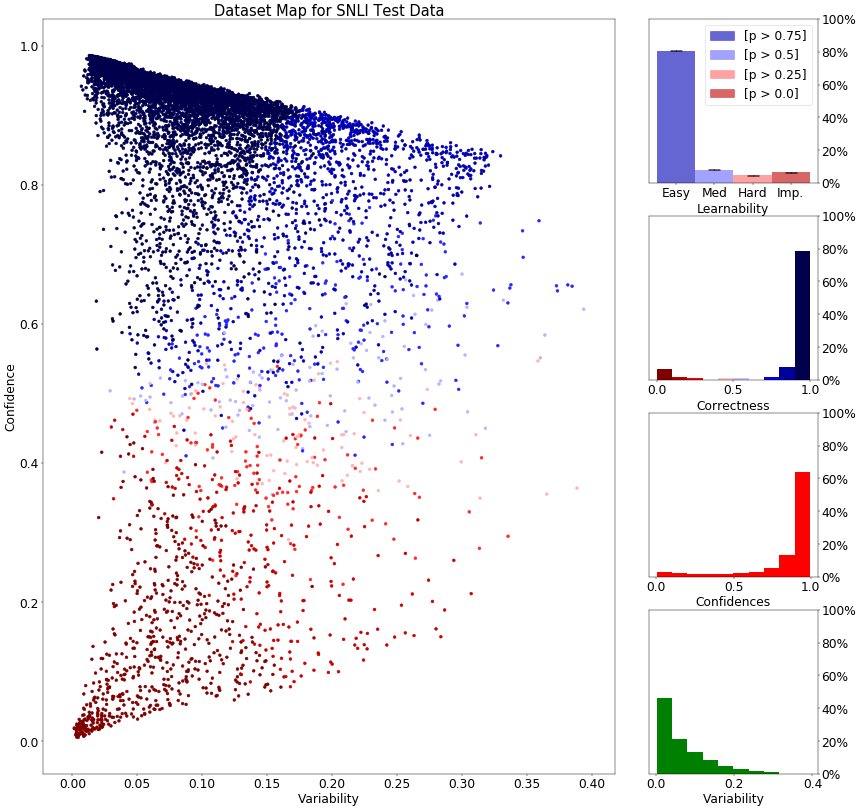

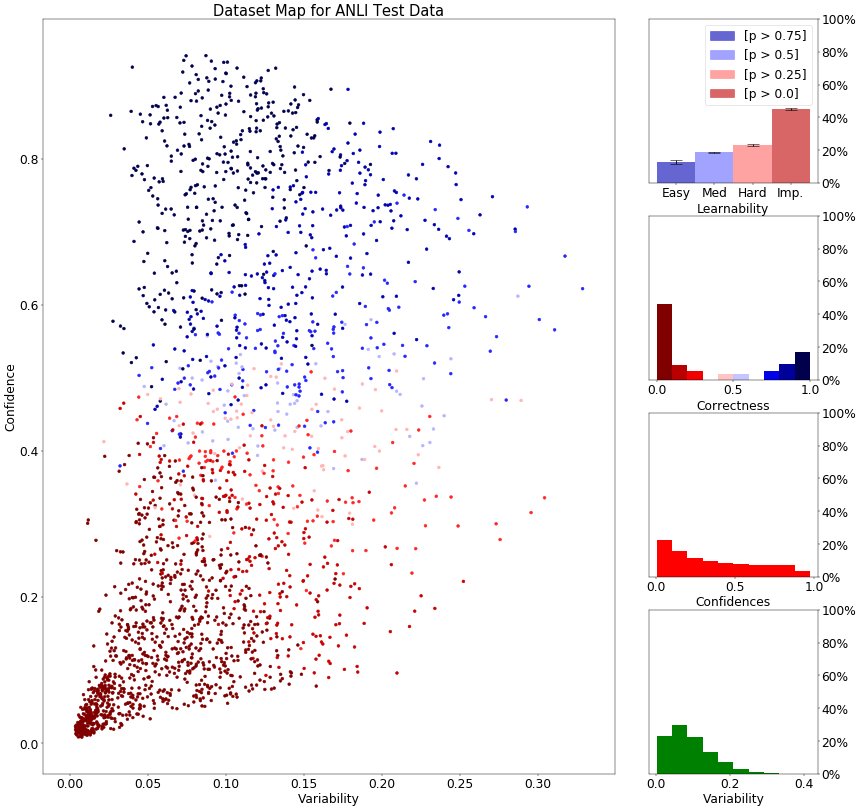

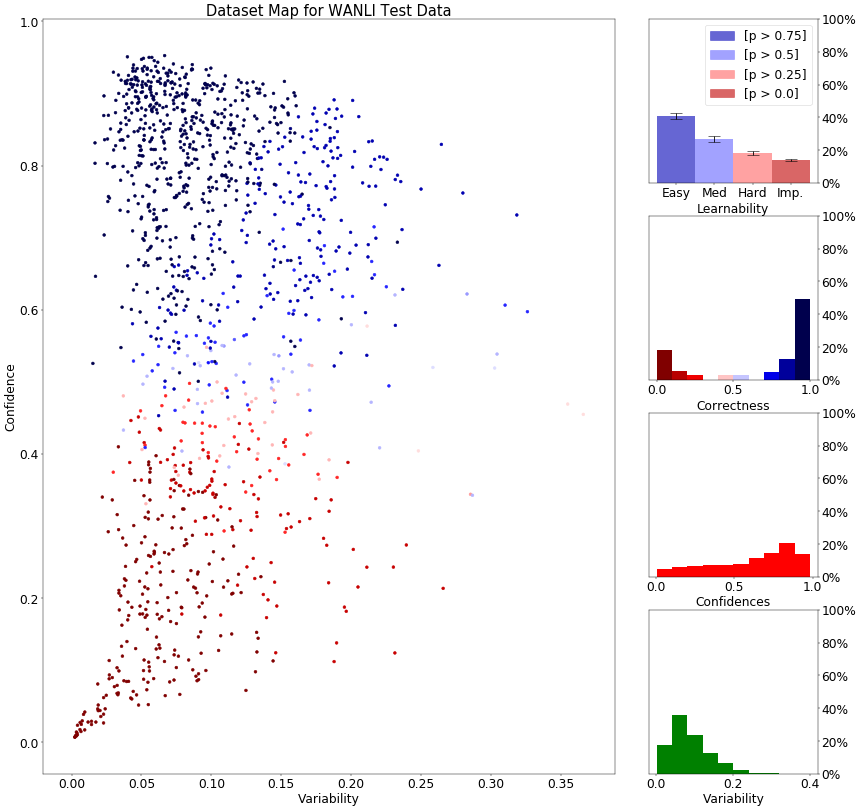

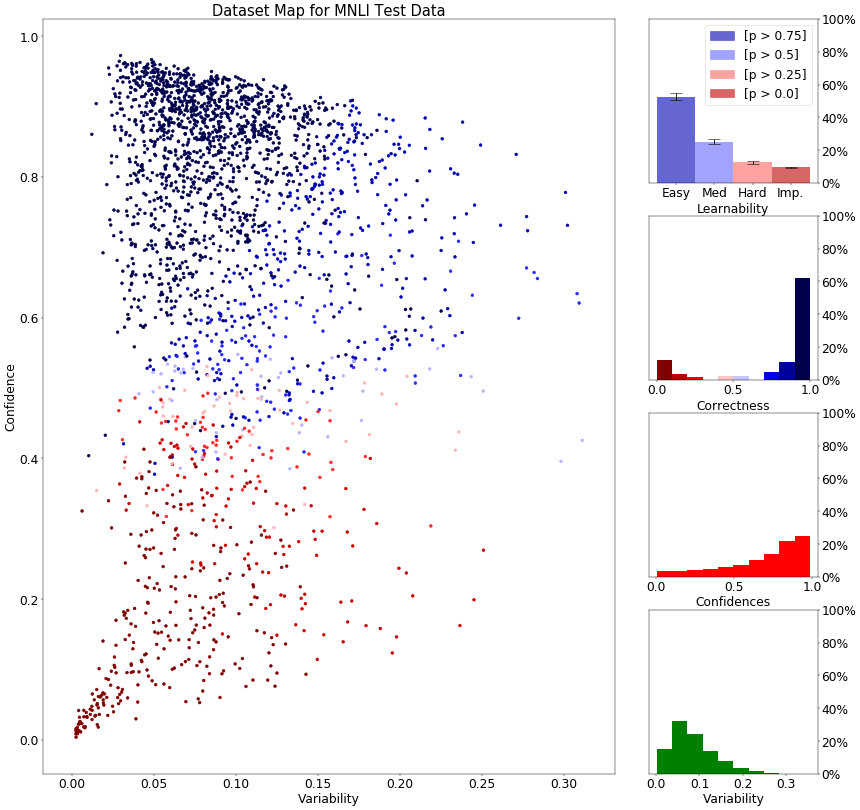

In [8]:
plt.rcParams['figure.dpi'] = 40
SIZE = 25
FONT_SIZE = 22
generate_dfs_2(snli_maps, size=SIZE, font_size=FONT_SIZE)
generate_dfs_2(anli_maps, size=SIZE, font_size=FONT_SIZE)
generate_dfs_2(wanli_maps, size=SIZE, font_size=FONT_SIZE)
generate_dfs_2(mnli_maps, size=SIZE, font_size=FONT_SIZE)

# Performance per strategy per difficulty segment per dataset

In [25]:
"""
To do:
Per seed, per strategy kijken hoeveel test examples ze goed hebben van:
- makkelijk
- medium
- moeilijk
- onmogelijk
"""

test_pred_path = '/Users/ardsnijders/Documents/GitHub/Lisa/active_learning/results/ard_output_dir_results/test_predictions/array/OOD_MNLI_active_learning_array_remove_bottom_025_poging_4/STRATEGY/SEED/DATASET/test_predictions.pickle'


source_maps = [snli_maps, anli_maps, wanli_maps, mnli_maps]


def compute_acc_per_difficulty(difficulty_str, strategy_str):
    for difficulty in [difficulty_str]:

        total_corr = []
        total_ex = []

        for datamaps in source_maps:

            for strategy in [strategy_str]:

                    tally = []
                    for datamap, seed in zip(datamaps, SEEDS):

                        dataset_id = (datamap.Name.iloc[0])

                        pred_path = test_pred_path.replace('SEED',str(seed)).replace('STRATEGY', strategy).replace('DATASET', dataset_id)

                        test_predictions = load_confidences(pred_path, predictions=False, exclude=0)

                        if difficulty == 'easy':
                            pred_segments = datamap[(datamap.mean_conf > EASY_THRESH)]

                        if difficulty == 'medium':
                            pred_segments = datamap[(datamap.mean_conf > MEDIUM_THRESH) & (datamap.mean_conf < EASY_THRESH)]

                        if difficulty == 'hard':
                            pred_segments = datamap[(datamap.mean_conf > HARD_THRESH) & (datamap.mean_conf < MEDIUM_THRESH)]

                        if difficulty == 'impossible':
                            pred_segments = datamap[(datamap.mean_conf < HARD_THRESH)]

                        segment_acc = np.mean(test_predictions[test_predictions.id.isin(pred_segments.id)].correctness)
                        tally.append(segment_acc)

    #                     print(np.sum(test_predictions[test_predictions.id.isin(pred_segments.id)].correctness))

                        total_corr.append( int(np.sum(test_predictions[test_predictions.id.isin(pred_segments.id)].correctness)) )
                        total_ex.append( len(pred_segments) )


                    print('mean accuracy, std on {} {} examples for {}: {} - {}'.format(difficulty, dataset_id, strategy, round(np.mean(tally)*100,1), round(np.std(tally)*100,1)))

        result = [round(x/y,3) for x,y in zip(total_corr, total_ex)]
        print('\n{} - mean accuracy, std over all {} examples: {} - {}\n'.format(strategy_str, difficulty,
                                                                   np.round(np.mean(result)*100,1),
                                                                   np.round(np.std(result)*100,1)))

for strategy in ['random', 'mc-max-entropy', 'bald', 'dal']:
    compute_acc_per_difficulty('easy', strategy_str=strategy)
    compute_acc_per_difficulty('medium', strategy_str=strategy)
    compute_acc_per_difficulty('hard', strategy_str=strategy)
    compute_acc_per_difficulty('impossible', strategy_str=strategy)

mean accuracy, std on easy SNLI examples for random: 95.4 - 0.8
mean accuracy, std on easy ANLI examples for random: 80.4 - 4.8
mean accuracy, std on easy WANLI examples for random: 94.7 - 1.4
mean accuracy, std on easy MNLI examples for random: 93.4 - 2.1

random - mean accuracy, std over all easy examples: 91.0 - 6.7

mean accuracy, std on medium SNLI examples for random: 69.6 - 2.6
mean accuracy, std on medium ANLI examples for random: 62.2 - 2.7
mean accuracy, std on medium WANLI examples for random: 72.7 - 3.2
mean accuracy, std on medium MNLI examples for random: 72.6 - 3.8

random - mean accuracy, std over all medium examples: 69.3 - 5.3

mean accuracy, std on hard SNLI examples for random: 46.3 - 3.5
mean accuracy, std on hard ANLI examples for random: 39.3 - 3.3
mean accuracy, std on hard WANLI examples for random: 41.9 - 2.7
mean accuracy, std on hard MNLI examples for random: 41.8 - 3.8

random - mean accuracy, std over all hard examples: 42.3 - 4.2

mean accuracy, std on im

# Performance per strategy per difficulty segment for all data

In [33]:
DATASETS = ['WANLI']

def aggregate_predictions(strategies):
    
    preds_per_strategy = []
    for strategy in strategies:

        # aggregate predictions over all datasets over all seeds
        agg_over_seeds = []
        for seed in SEEDS:

            # aggregate predictions over all datasets
            agg_over_datasets = []
            for dataset_id in DATASETS:

                prediction_path = test_pred_path.replace('SEED', str(seed)).replace('STRATEGY', strategy).replace('DATASET', dataset_id)

                test_predictions = load_confidences(prediction_path, predictions=False, exclude=0)
                agg_over_datasets.append(test_predictions)

            df_for_all_datasets = pd.concat(agg_over_datasets) # combine for all datasets,
#             print(df_for_all_datasets)

            agg_over_seeds.append(df_for_all_datasets)

        all_predictions = pd.concat(agg_over_seeds)
        preds_per_strategy.append(all_predictions)
        
    return preds_per_strategy

4708

In [12]:
def aggregate_maps_over_seeds(maps_list):
    
    maps_per_source = []
    for datamaps in maps_list:
        
        aggregate_map = pd.concat([datamap for datamap in datamaps]).groupby('id').mean()
        maps_per_source.append(aggregate_map)
        
    return maps_per_source
        
def aggregate_maps_over_sources(maps_list):
    
    return pd.concat(aggregate_maps_over_seeds(maps_list))
    
complete_map = aggregate_maps_over_sources([snli_maps, anli_maps, wanli_maps, mnli_maps])

In [13]:
easy = complete_map[complete_map.mean_conf > EASY_THRESH]
medium = complete_map[(complete_map.mean_conf > MEDIUM_THRESH) & (complete_map.mean_conf < EASY_THRESH)]
hard = complete_map[(complete_map.mean_conf > HARD_THRESH) & (complete_map.mean_conf < MEDIUM_THRESH)]
impossible = complete_map[complete_map.mean_conf < HARD_THRESH]

In [14]:
random_predictions

[          id  mean_conf  variability  correctness
 0     276736   0.913072          0.0          1.0
 1     152465   0.389430          0.0          0.0
 2      33339   0.952567          0.0          1.0
 3     195850   0.494612          0.0          0.0
 4     284917   0.297490          0.0          0.0
 ...      ...        ...          ...          ...
 2460  130537   0.987579          0.0          1.0
 2461  333820   0.801645          0.0          1.0
 2462  162086   0.009525          0.0          0.0
 2463  371164   0.304923          0.0          0.0
 2464  325724   0.995773          0.0          1.0
 
 [12319 rows x 4 columns]]

# Datamaps per Strategy

In [15]:
def load_strategy_acquisitions(path, strategy, cap=4000):
    
    acquired_df = pd.read_csv(path)
    acquired_df = acquired_df[:cap]
    acquired_df['Name'] = strategy.capitalize()
    
    return acquired_df

def get_subset_list(strategy_path, base_path, strategy_list):
    
    subset_list = []
    
    for strategy in strategy_list:
        
        strategy_list = []
        
        for seed in SEEDS:
            
            _base_path = base_path.replace('SEED', str(seed))
            _strategy_path = strategy_path.replace('SEED', str(seed)).replace('STRATEGY', str(strategy))
            
            strategy_df = load_strategy_acquisitions(path=_strategy_path, strategy=strategy)

            
            base_df = load_confidences(_base_path)

            id2dataset = {}
            for i in range(len(strategy_df)):
                row = strategy_df.iloc[i]
                id2dataset[row.ID] = row.Dataset

            strategy_subset = datamap_subset(base_df=base_df, source_df=strategy_df, name=strategy)
            strategy_subset['Dataset'] = strategy_subset['id'].apply(lambda x: id2dataset[x])
            
            strategy_list.append(strategy_subset)
        
        subset_list.append(strategy_list)

    return subset_list 

subset_list = get_subset_list(strategy_path=STRATEGY_PATH, base_path=BASE_PATH, strategy_list=['random', 'bald', 'mc-max-entropy', 'dal'])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

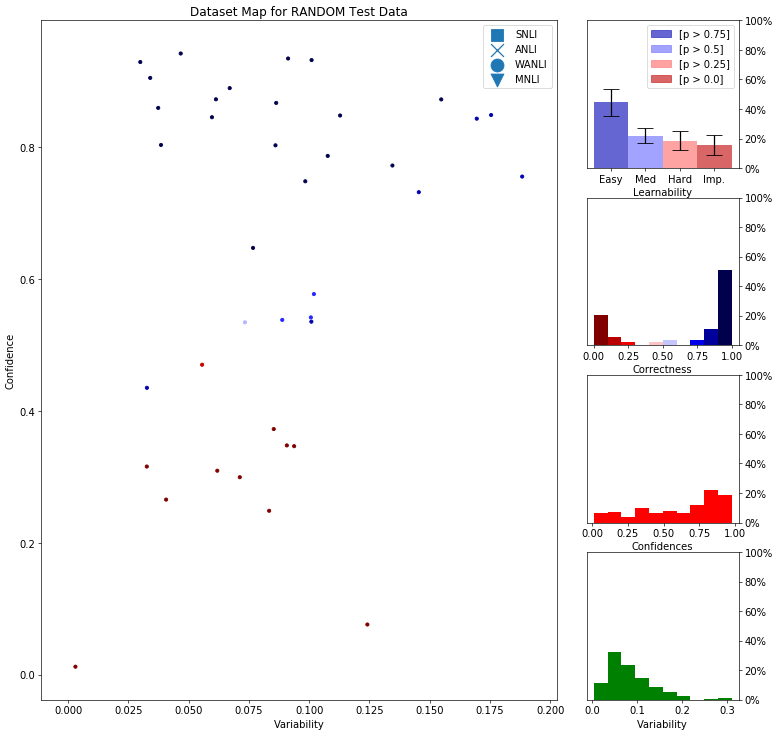

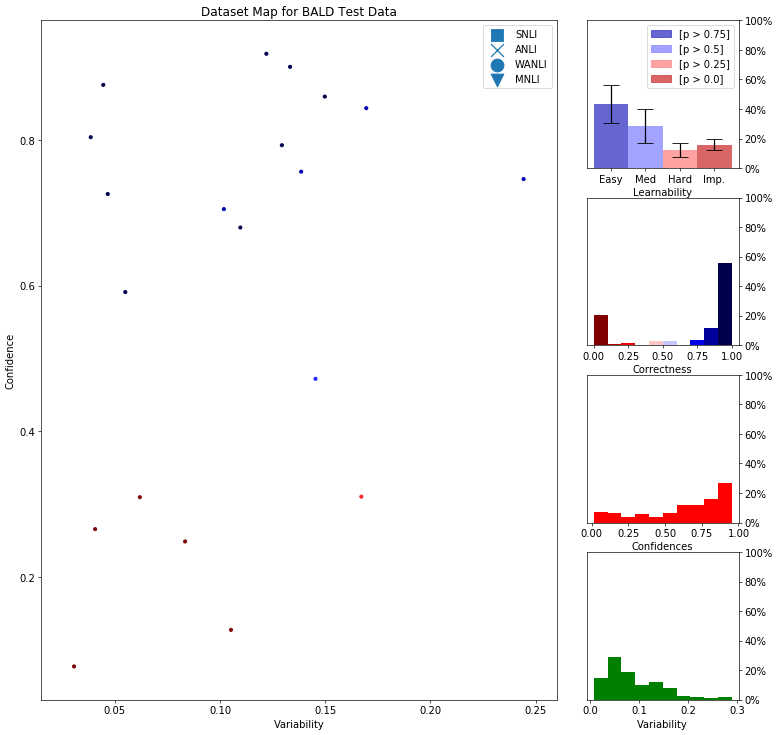

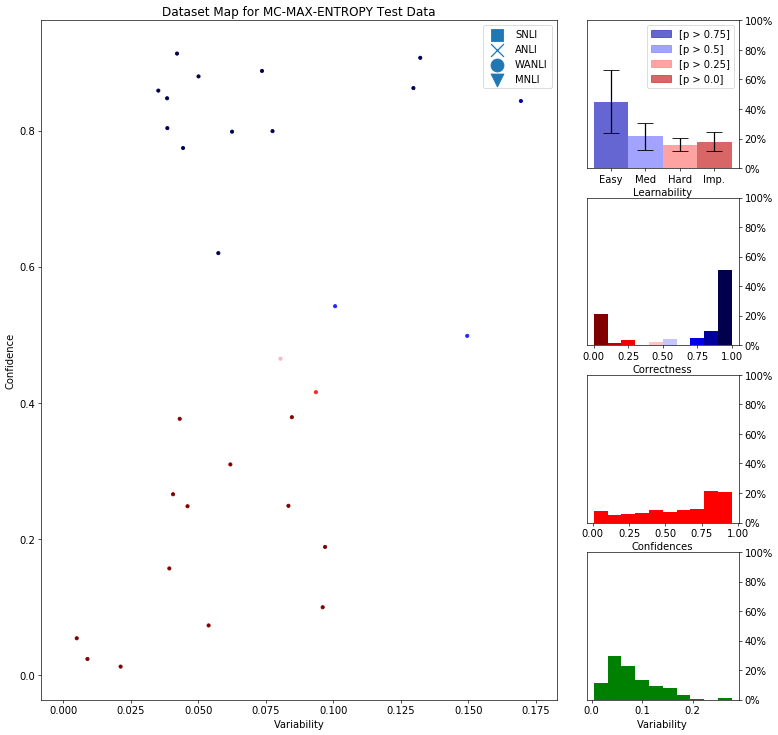

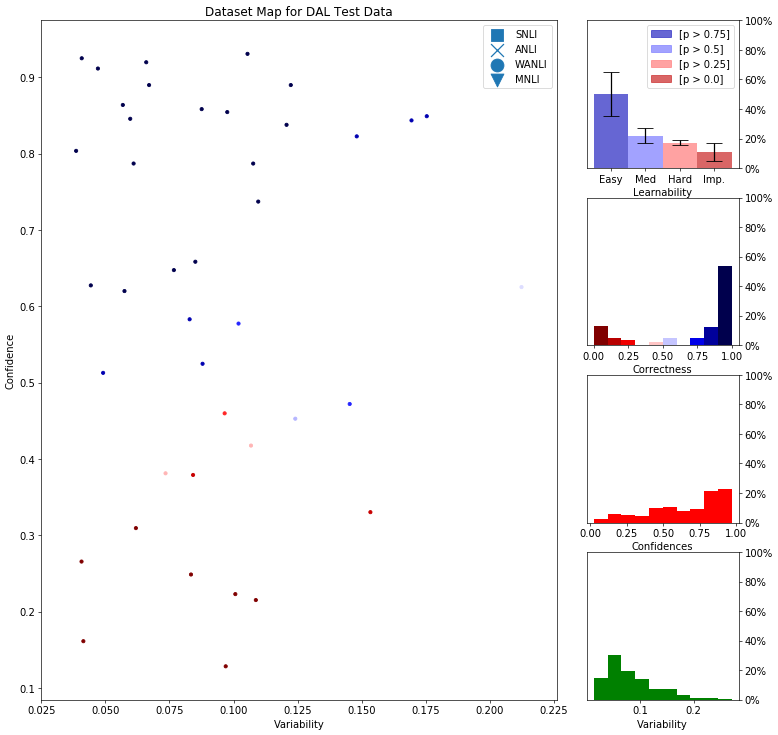

In [16]:
# generate_dfs(subset_list, markers=True, size=100, n_bins=10)

plt.rcParams['figure.dpi'] = 60
SIZE = 15
FONT_SIZE = 12

for subset_maps in subset_list:
    generate_dfs_2(subset_maps, markers=True, size=SIZE, font_size=FONT_SIZE)

# Acquisitions by Difficulty over Time

In [17]:
def generate_stacked_barchart(base_dfs, strategy_dfs, return_axs=False, size=20, font_size=22, dpi=40):
    
    plt.rcParams.update({'font.size': font_size})
    # Call this fn for a single strategy!
    
    num_easy_aggregate = []
    num_medium_aggregate = []
    num_hard_aggregate = []
    num_impossible_aggregate = []
    
    for strategy_df, base_df in zip(strategy_dfs, base_dfs):
        
        number_of_examples = 500

        labels = []
        num_easy = []
        num_medium = []
        num_hard = []
        num_impossible = []

        easy_thresh = 0.75
        medium_thresh = 0.5
        hard_thresh = 0.25
        impossible_thresh = 0.0

        for active_round in range(1, strategy_df['round'].max()+1):

            acquisitions = strategy_df[strategy_df['round']==active_round]
            number_of_examples += len(acquisitions)
            labels.append(number_of_examples)

            confidences = base_df[base_df.id.isin(acquisitions.ID)]

            easy_mask = confidences.mean_conf > easy_thresh
            medium_mask = (confidences.mean_conf > medium_thresh) & (confidences.mean_conf < easy_thresh)
            hard_mask = (confidences.mean_conf > hard_thresh) & (confidences.mean_conf < medium_thresh)
            impossible_mask = (confidences.mean_conf > impossible_thresh) & (confidences.mean_conf < hard_thresh)

            num_easy.append(len(confidences[easy_mask]))
            num_medium.append(len(confidences[medium_mask]))
            num_hard.append(len(confidences[hard_mask]))
            num_impossible.append(len(confidences[impossible_mask]))
            
        num_easy_aggregate.append(num_easy)
        num_medium_aggregate.append(num_medium)
        num_hard_aggregate.append(num_hard)
        num_impossible_aggregate.append(num_impossible)
        
    def get_mean_and_std_e(array):
        
        return np.mean(array, axis=0), np.std(array, axis=0)
    
    num_easy, num_easy_std = get_mean_and_std_e(num_easy_aggregate)    
    num_medium, num_medium_std = get_mean_and_std_e(num_medium_aggregate)
    num_hard, num_hard_std = get_mean_and_std_e(num_hard_aggregate)
    num_impossible, num_impossible_std = get_mean_and_std_e(num_impossible_aggregate)  

    fig, ax = plt.subplots(figsize=(size,size))
    plt.rcParams['figure.dpi'] = dpi

    width = 210
    alpha = ALPHA
    labels = np.array(labels)

    cmap = mpl.cm.get_cmap(CMAP)

    ax.bar(labels, num_easy, width, yerr=num_easy_std, label='Easy [p > {}]'.format(easy_thresh), color=cmap(0.85), alpha=alpha)
    ax.bar(labels, num_medium, width, yerr=num_medium_std, bottom=num_easy,  label='Medium [p > {}]'.format(medium_thresh), color=cmap(0.65), alpha=alpha)
    ax.bar(labels, num_hard, width, yerr=num_hard_std, bottom=num_easy + num_medium, label='Hard [p > {}]'.format(hard_thresh), color=cmap(0.35), alpha=alpha)
    ax.bar(labels, num_impossible, width, yerr=num_impossible_std, bottom=num_easy + num_medium + num_hard, label='Impossible [p > {}]'.format(impossible_thresh), color=cmap(0.125), alpha=alpha)

    ax.set_xticks(ax.get_xticks()[2:])
    ax.set_ylabel('Acquisition by Difficulty')
    ax.set_xlabel('Number of Training Examples')
    ax.set_ylim(0, 260)
    ax.set_title(strategy_df['Name'].tolist()[0]+' - Acquisitions by Difficulty')
    ax.legend(loc='lower right')
    
    if return_axs:
        
        return ax
    
    else:
        
        plt.plot(stacked=True)
        name = strategy_df['Name'].tolist()[0]
        plt.savefig('acquisitions_by_difficulty_{}_seed_{}'.format(name,seed))
        plt.show()
        
        return None
    

def generate_stacked_barchart_data(base_dfs, strategy_dfs, return_axs=False, impossible_only=False, size=20, font_size=22, dpi=40):
    
    plt.rcParams.update({'font.size': font_size})
    # Call this fn for a single strategy!
    
    total_counts = {'SNLI':[], 'ANLI':[], 'WANLI':[]}
    
    for strategy_df, base_df in zip(strategy_dfs, base_dfs):
        
        number_of_examples = 500

        labels = []
        results = {'SNLI':[], 'ANLI':[], 'WANLI':[]}

        for active_round in range(1, strategy_df['round'].max()+1):

            acquisitions = strategy_df[strategy_df['round']==active_round]
            number_of_examples += len(acquisitions)
            
            if impossible_only:
                
                impossible_acquisitions = base_df[base_df.mean_conf < HARD_THRESH]
                acquisitions = acquisitions[acquisitions.ID.isin(impossible_acquisitions.id)]
            
            labels.append(number_of_examples)
            
            data_counts = acquisitions.Dataset.value_counts()
            
            for dataset, value in zip(data_counts.index, data_counts):
                results[dataset].append(value)
            
            for dataset in list(results.keys()):
                
                if dataset not in data_counts.index:
                    
                    results[dataset].append(0)
        
        for key in list(total_counts.keys()):
            total_counts[key].append(results[key])
        
    mean_and_std = {'SNLI':[], 'ANLI':[], 'WANLI':[]}
    
    for key in list(results.keys()):
        mean_and_std[key].append(np.mean(total_counts[key], axis=0))
        mean_and_std[key].append(np.std(total_counts[key], axis=0))
        
    def get_mean_and_std_e(array):
        
        return np.mean(array, axis=0), np.std(array, axis=0) 

    fig, ax = plt.subplots(figsize=(size,size))
    plt.rcParams['figure.dpi'] = dpi
    
    if impossible_only:
        ax.set_ylim(0, 50)
    else:
        ax.set_ylim(0, 260)
        
    width = 210
    alpha = ALPHA
    labels = np.array(labels)

    cmap = mpl.cm.get_cmap(_CMAP)
    
    ax.bar(labels, mean_and_std['SNLI'][0], width, yerr=mean_and_std['SNLI'][1], label='SNLI', color=cmap(0.85), alpha=alpha)
    ax.bar(labels, mean_and_std['ANLI'][0], width, yerr=mean_and_std['ANLI'][1], bottom=mean_and_std['SNLI'][0],  label='ANLI', color=cmap(0.65), alpha=alpha)
    ax.bar(labels, mean_and_std['WANLI'][0], width, yerr=mean_and_std['WANLI'][1], bottom=mean_and_std['SNLI'][0] + mean_and_std['ANLI'][0], label='WANLI', color=cmap(0.35), alpha=alpha)

    ax.set_xticks(ax.get_xticks()[2:])
    ax.set_ylabel('Acquisition by Dataset')
    ax.set_xlabel('Number of Training Examples')
    
    if not impossible_only:     
        ax.set_title(strategy_df['Name'].tolist()[0]+' - Acquisitions by Dataset')
        
    else:
        ax.set_title(strategy_df['Name'].tolist()[0]+' - Imp. Acquisitions by Dataset')
    
    ax.legend(loc='lower right')
    
    if return_axs:
        
        return ax
    
    else:
        
        plt.plot(stacked=True)
        name = strategy_df['Name'].tolist()[0]
        plt.savefig('acquisitions_by_data_{}_seed_{}'.format(name,seed))
        plt.show()
        
        return None

In [18]:
strategy_ids = ['random', 'max-entropy', 'mc-max-entropy', 'dal', 'bald']

strategies_list = []
for strategy_id in strategy_ids:
    
    strategy_list = []
    for seed in SEEDS:
        
        strategy_path = STRATEGY_PATH.replace('SEED', str(seed)).replace('STRATEGY', str(strategy_id))
        strategy_df = load_strategy_acquisitions(strategy=strategy_id, path=strategy_path) 
        
        strategy_list.append(strategy_df)
    
    strategies_list.append(strategy_list)

In [19]:
base_dfs = [load_confidences(BASE_PATH.replace('SEED', str(seed)), predictions=False) for seed in SEEDS]

In [20]:
base_dfs[0]

,id,mean_conf,variability,correctness
0,2677109430.jpg#1r1n,0.856797,0.129124,1.000000
1,2677109430.jpg#1r1e,0.661288,0.104505,0.857143
2,2677109430.jpg#1r1c,0.970684,0.025171,1.000000
3,6160193920.jpg#4r1n,0.880483,0.092355,1.000000
4,6160193920.jpg#4r1e,0.409567,0.037043,0.000000
...,...,...,...,...
19392,19768e,0.693017,0.042896,1.000000
19393,117680c,0.771595,0.148959,1.000000
19394,11876e,0.141856,0.027361,0.000000
19395,72032c,0.909874,0.039028,1.000000


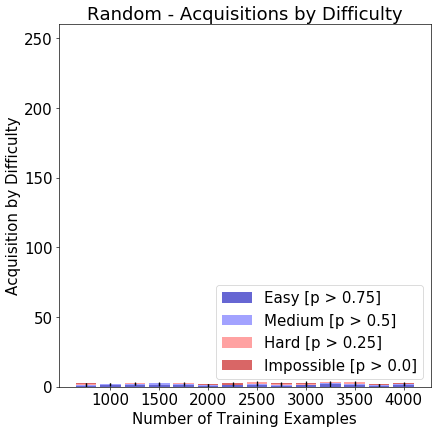

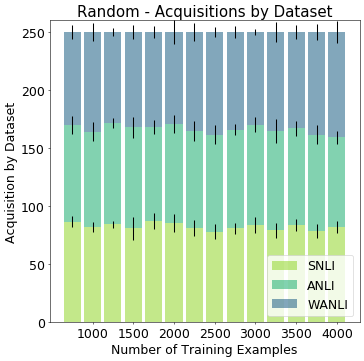

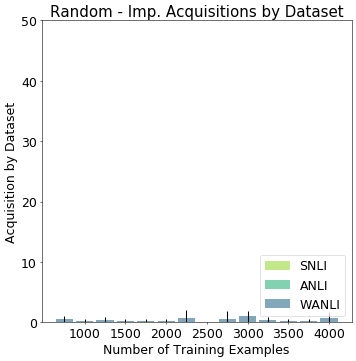

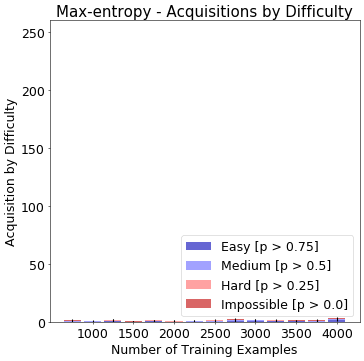

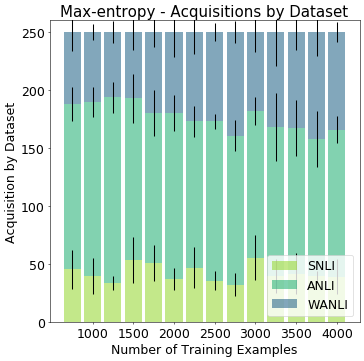

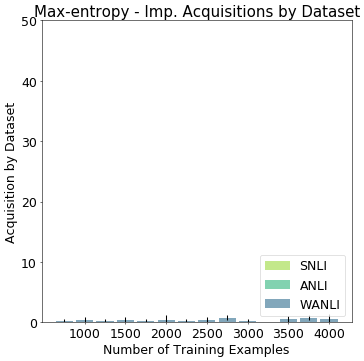

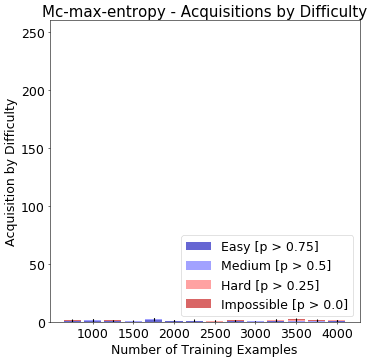

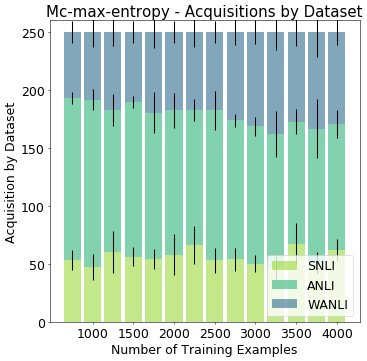

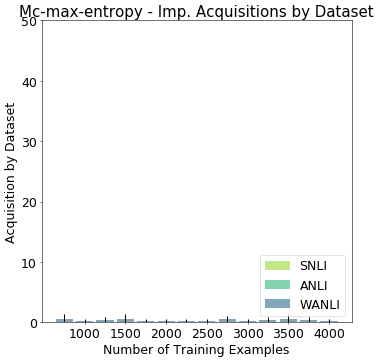

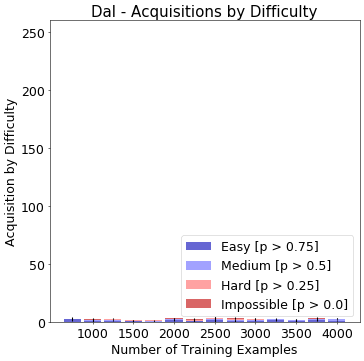

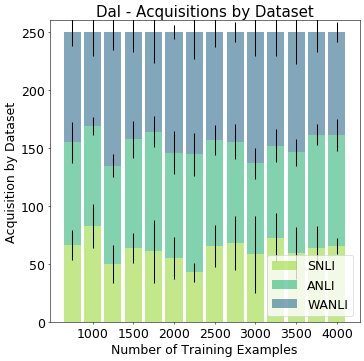

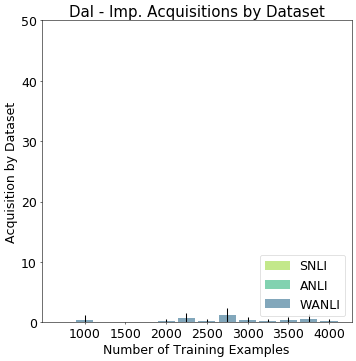

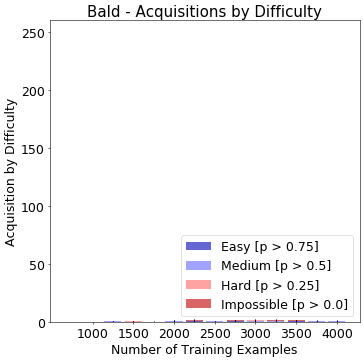

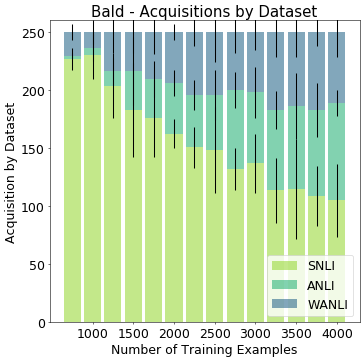

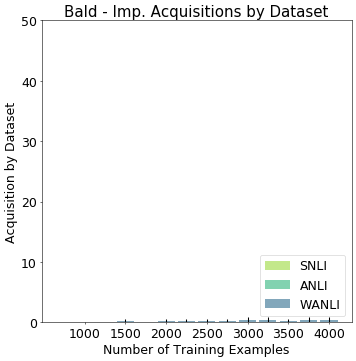

In [21]:
axs = []
for strategy_df in strategies_list:
     ax = generate_stacked_barchart(base_dfs=base_dfs, strategy_dfs=strategy_df, return_axs=False, size=8, font_size=18, dpi=50)
     ax = generate_stacked_barchart_data(base_dfs=base_dfs, strategy_dfs=strategy_df, impossible_only=False, return_axs=False, size=8, font_size=18, dpi=50)
     ax = generate_stacked_barchart_data(base_dfs=base_dfs, strategy_dfs=strategy_df, impossible_only=True, return_axs=False, size=8, font_size=18, dpi=50)

# Examples of various difficulties:

In [22]:
EASY_THRESH = 0.75
MEDIUM_THRESH = 0.5
HARD_THRESH = 0.25
IMPOSSIBLE_THRESH = 0.0

COL_WIDTH = 25

_, prediction_dict = load_confidences(BASE_PATH.replace('SEED',str(42)), predictions=True)

def show_examples(source_df, source_map, base_df=None, num=5):
    
    source_map = source_map[0]
    
    difficulty_dict = {}
    
    easy_mask = source_map.mean_conf > EASY_THRESH
    medium_mask = (source_map.mean_conf > MEDIUM_THRESH) & (source_map.mean_conf < EASY_THRESH)
    hard_mask = (source_map.mean_conf > HARD_THRESH) & (source_map.mean_conf < MEDIUM_THRESH)
    impossible_mask = (source_map.mean_conf > IMPOSSIBLE_THRESH) & (source_map.mean_conf < HARD_THRESH)
    
    difficulty_dict['Easy'] = source_map[easy_mask]
    difficulty_dict['Medium'] = source_map[medium_mask]
    difficulty_dict['Hard'] = source_map[hard_mask]
    difficulty_dict['Impossible'] = source_map[impossible_mask]
    
    print('Examples from classes EASY, MEDIUM, HARD, and IMPOSSIBLE for {} \n'.format(source_map.Name.tolist()[0]))
    
    print('\nConfidence Thresholds:\nEasy: {}\nMedium: {}\nHard: {}\nImpossible: {}\n'.format(EASY_THRESH, MEDIUM_THRESH, HARD_THRESH, IMPOSSIBLE_THRESH))
    
    id2label = {0: "entailment",
                1: "contradiction",
                2: "neutral"}
    for key in difficulty_dict.keys():
        
        examples = source_df[source_df.ID.astype('str').isin(difficulty_dict[key].id.astype('string'))].head(num)
        examples['Model Prediction'] = examples.ID.apply(lambda x: id2label[np.argmax(prediction_dict[x]['prediction'])])
        
        print(str(key).capitalize() + ' examples:')
        examples = examples[['Premise', 'Hypothesis', 'Label', 'Model Prediction']]
        examples['Hypothesis'] = examples['Hypothesis'].str.wrap(COL_WIDTH).astype('string')
        examples['Premise'] = examples['Premise'].str.wrap(COL_WIDTH).astype('string')
        
        examples = examples.style.set_properties(**{'text-align': 'left'})
        examples = examples.set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])])
        display(examples)
   

show_examples(source_df=snli, source_map=snli_maps, base_df=None, num=20)

Examples from classes EASY, MEDIUM, HARD, and IMPOSSIBLE for WANLI 


Confidence Thresholds:
Easy: 0.75
Medium: 0.5
Hard: 0.25
Impossible: 0.0

Easy examples:


,Premise,Hypothesis,Label,Model Prediction
3258,"A large marble fountain, designed by architect Paul Manship, features the city's coat of arms, the words ""San Francisco"" and the motto ""Oro en Paz"" (Gold in Peace).","The city's motto is ""Gold in Peace"" but the residents are too lazy to clean up the fountain.",neutral,neutral
1715,"A long, long time ago, in a galaxy far, far away, a galactic senate of intergalactic lawgivers was faced with a crisis.",The Senate of the Galactic Republic was faced with a crisis.,neutral,neutral
3938,"Under the proposal, the Company would be required to adopt a compensation plan that would provide for annual cash bonuses for all of its employees.",The plan would provide for cash bonuses for all employees.,entailment,entailment
1792,"I'm not saying that the job is perfect, but it's not the end of the world either.",The job is not the end of the world.,entailment,entailment
3267,The stranger's face was expressionless.,The stranger was bored.,neutral,neutral
4290,"When this shift occurs, it will be important to focus on the strengths of the organization and its people.",Strengths are important in an organization.,entailment,entailment
2821,That's a very interesting point of view.,I agree with you.,neutral,neutral
2345,"A common example of this is the distinction between an ""option"" and an ""option contract"".",The distinction is not valid.,neutral,neutral
2598,This example is very close to the second example.,The examples are very close to each other.,entailment,entailment
3061,"""The Times"" says the Prime Minister is being driven to distraction by the war.",The Prime Minister is very angry with the war.,neutral,neutral


Medium examples:


,Premise,Hypothesis,Label,Model Prediction
57,I thought you might be able to tell me something about the letters Mrs. Inglethorp wrote last night.,I thought Annie might be able to tell me something about the letters written by Mrs. Inglethorp last night.,neutral,neutral
1671,"A survey of the attitudes of students in high school found that the most common response to the question, ""What do you want to be when you grow up?"" was ""A doctor.""","A survey of the attitudes of students in high school found that the most common response to the question, ""What do you want to be when you grow up?"" was ""A teacher.""",contradiction,contradiction
3037,"If the two lines of the image are separated by a space, the lines will appear to be parallel.",The lines of the image are not parallel.,neutral,neutral
1396,It's a matter of personal preference.,I think it's a matter of personal preference.,entailment,entailment
2820,There are many people who feel that the time has come to start working on this.,It was not a fact that people should start working on this.,neutral,neutral
3287,"If he is found guilty, he will be executed.",He will be executed.,neutral,neutral
4596,These findings suggest that the government has been successful in reducing its dependence on foreign oil.,The government has been successful in reducing its dependence on foreign oil.,neutral,neutral
1325,I have always thought that the president should be required to certify that the actions he is taking are consistent with the Constitution.,The president should be required to do so.,neutral,neutral
4303,I'll be there.,I'll be there soon.,neutral,neutral
2902,The English version of the story is quite different from the French version.,The French version is quite different from the English version.,entailment,entailment


Hard examples:


,Premise,Hypothesis,Label,Model Prediction
684,This would be the first federal agency to be led by a person of color.,Not all federal agencies are led by people of color.,entailment,entailment
2869,The loss of our American jobs to other countries is a direct result of the trade policies of the Bush Administration.,The loss of American jobs to other countries is a direct result of the trade policies of the Clinton Administration.,neutral,contradiction
2780,A major purpose of the bill is to increase the transparency of government.,Transparency is important.,entailment,neutral
271,"He thought of his friend in the army, in a way he never had before, and he realized that he had been a little bit in love with him.",He was in love with his friend in the army.,entailment,neutral
4304,"An alternative, and perhaps more useful, approach is to focus on the interaction between the content of the argument and the way in which it is presented.",The argument is presented in a particular way.,entailment,entailment
4069,"In fact, I think that the music of the ""nuevo flamenco"" is as good as the music of the ""flamenco de gaita"" of the 19th century.",Flamenco is alive and well.,neutral,entailment
469,"In a way, the law can be seen as a public good, a good that is available to all, but its provision is contingent on the actions of a relatively small number of people.","The law is a public good, but it is provided by a small number of people.",neutral,entailment
4235,There is no question that the US will be a superpower in the next century.,There is no question that the US will not be a superpower in the next century.,contradiction,neutral
4399,"The best and most important step in preventing and controlling crime is to establish and maintain a well-organized, well- trained, and well- equipped police force.","The best and most important step in preventing and controlling crime is to establish and maintain a well-organized, well- trained, and well- equipped fire department.",contradiction,neutral
1725,Many people visit the city for its famous Roman ruins.,There are many ruins in the city.,neutral,entailment


Impossible examples:


,Premise,Hypothesis,Label,Model Prediction
389,What's the worst that can happen?,The worst that can happen is that nothing will happen.,contradiction,neutral
3307,"It is a matter of record that during the period of his imprisonment, Jefferson wrote most of the Declaration of Independence.",The Declaration of Independence is a document that was written by Thomas Jefferson.,neutral,entailment
4965,"She is an excellent shot, but her record is better than that of any other woman in the country.",She is the best shot in the country.,entailment,neutral
3510,"He went on to explain that he had always believed that it was the duty of the people to govern themselves, and that they should not be governed by any man, or by any group of men, no matter how intelligent or powerful they might be.",The people should govern themselves.,neutral,entailment
3990,The final exam will be a two-hour oral exam that will include a written component.,The final exam will be a two-hour written exam that will include a two- hour oral component.,contradiction,entailment
3900,The opportunity to make a statement in a manner that is completely truthful and in a way that will be remembered for a long time.,It is the only way to make a statement.,contradiction,neutral
2310,It is not clear whether the increase in international capital flows is due to the Federal Reserve's tight monetary policy or to the depreciation of the dollar.,The Federal Reserve's tight monetary policy is the only reason why the value of the dollar has declined.,contradiction,neutral
571,"In a dark, damp basement in the eastern part of the city, a little-known museum is displaying a remarkable collection of paintings by a single artist, Ettore Tito.",The museum has a large collection of paintings by a single artist.,neutral,entailment
3236,"For example, in an economy that is growing at a rate of 2 percent, a 2 percent increase in government spending will have a 1 percent effect on the economy.",The effect of government spending is a 1 percent increase.,neutral,entailment
3446,"He has the typical characteristics of a poor child, a fat face, a stammer, and a love of sweets.",He is a typical child.,neutral,entailment


# Uncertainty metric:

In [27]:
def compute_uncertainty(strategies, base_path, strategy_path):
    
    results = {key: [] for key in strategies}
    
    for seed in SEEDS:
        
        print('Computing UNC for seed: {}'.format(seed))
        
        confidences = pd.read_pickle(base_path.replace('SEED', str(seed)))
        
        seed_entropies = {}
        
        sample_ids = list(confidences.keys())
        for sample_id in sample_ids:
    
            times_correct = []

            outputs = confidences[sample_id]
            output = outputs[-1] # last epoch
            
            prediction = output[0]
            pred_entropy = entropy(prediction)
            seed_entropies[sample_id] = pred_entropy
        
        def get_entropies(x):
            
            if x in seed_entropies.keys():
                return seed_entropies[x]
            else:
                return False
        
        for strategy in strategies:
            
            strategy_df = load_strategy_acquisitions(strategy=strategy, path=strategy_path.replace('SEED', str(seed)).replace('STRATEGY', str(strategy)))
            
            strategy_df['entropies'] = strategy_df.ID.apply(lambda x: get_entropies(x))
            uncertainty = np.mean(strategy_df.entropies.tolist())
            
            results[strategy].append(uncertainty)
        
    return results

uncertainty = compute_uncertainty(strategies=['random', 'bald', 'dal', 'mc-max-entropy'], base_path=BASE_PATH, strategy_path=STRATEGY_PATH)

Computing UNC for seed: 42
Computing UNC for seed: 43
Computing UNC for seed: 44
Computing UNC for seed: 45
Computing UNC for seed: 46


In [29]:
strats = ['random', 'bald', 'dal', 'mc-max-entropy']

def plot_uncertainty(uncertainty, size=15, dpi=60):
    
    fig, ax = plt.subplots(figsize=(size,size))
    plt.rcParams['figure.dpi'] = dpi

    width = 1
    alpha = ALPHA
    labels = np.array(range(len(uncertainty.keys())))

    cmap = mpl.cm.get_cmap(CMAP)
    
    for i, key in enumerate(strats):
        ax.bar(key, np.mean(uncertainty[key]), yerr=np.std(uncertainty[key]), width=width, label='{}'.format(key), color=cmap(i/len(labels)), alpha=alpha)

    
    ax.set_ylabel('Mean predictive entropy')
    ax.set_xlabel('Strategy')
    ax.set_ylim(0, 1)
    ax.set_title('Uncertainty per Strategy')
    ax.legend(loc='upper right')
    
    plt.savefig('uncertainty')
    plt.show()

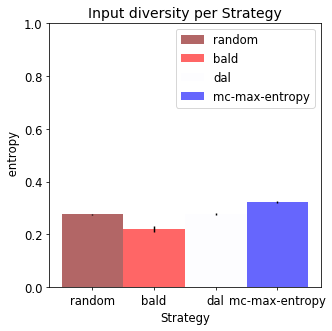

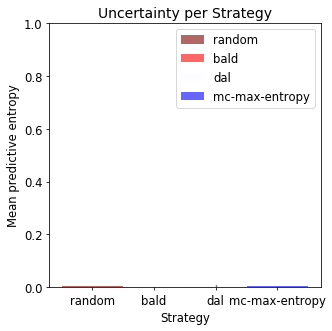

In [32]:
def plot_input_div(input_div, size=20, dpi=60):
    
    fig, ax = plt.subplots(figsize=(size,size))
    plt.rcParams['figure.dpi'] = dpi

    width = 1
    alpha = ALPHA
    labels = np.array(range(len(uncertainty.keys())))

    cmap = mpl.cm.get_cmap(CMAP)
    
    for i, key in enumerate(strats):
        ax.bar(key, input_div[key][0], yerr=input_div[key][1], width=width, label='{}'.format(key), color=cmap(i/len(labels)), alpha=alpha)

    
    ax.set_ylabel(' entropy')
    ax.set_xlabel('Strategy')
    ax.set_ylim(0, 1)
    ax.set_title('Input diversity per Strategy')
    ax.legend(loc='upper right')
    
    plt.savefig('input_div')
    plt.show()

input_div = {'dal':[0.2761, 0.004296],
'max-entropy': [0.3308, 0.01008],
'random': [0.2756, 0.00295],
'bald': [0.2203, 0.01226],
'mc-max-entropy':[0.3227, 0.00429]}

SIZE = 5
DPI = 70
FONT_SIZE = 12
plt.rcParams.update({'font.size': FONT_SIZE})
plot_input_div(input_div, size=SIZE, dpi=DPI)
plot_uncertainty(uncertainty, size=SIZE, dpi=DPI)

# TODO: find out if token overlap is a good enough signal to regularise towards target domain

In [26]:


anli_dev = anli.sample(5000)

anli_train = anli[-anli.ID.isin(anli_dev.ID)].sample(50000)
snli_train = snli.sample(50000)

def get_set_of_tokens(dataset):

            # join sentences from Premise and Hypothesis column into single string
            dataset['Combined'] = dataset['Premise'] + ' ' + dataset['Hypothesis']
            list_of_tokens = []
            # split each sentence into tokens and add to list
            for sentence in dataset['Combined'].tolist():
                for char in [',', '.', '?', '!', ':', ';',"'", '"', ')', '(', '<br>']:
                    sentence = sentence.replace(char, '').lower()
#                 dataset['Split_set'] = sentence.split()
                list_of_tokens.extend(sentence.split())
            # return set of unique tokens
            return dataset, set(list_of_tokens)

ValueError: Cannot take a larger sample than population when 'replace=False'

In [ ]:
anli_train, anli_train_tokens = get_set_of_tokens(anli_train)
snli_train, snli_train_tokens = get_set_of_tokens(snli_train)
anli_dev, anli_dev_tokens = get_set_of_tokens(anli_dev)

In [ ]:
# anli_intersection = anli_train_tokens.intersection(anli_dev_tokens)
# snli_intersection = snli_train_tokens.intersection(anli_dev_tokens)

# print(len(anli_intersection)/len(anli_train_tokens))
# print(len(snli_intersection)/len(snli_train_tokens))

def compute_mean_overlap(train_df, dev_set):
    overlap = []
    for sentence in train_df.Combined:
        for char in [',', '.', '?', '!', ':', ';',"'", '"', ')', '(', '<br>']:
            sentence = sentence.replace(char, '').lower()

            overlap.append(len(set(sentence).intersection(dev_set)))
            
    return np.mean(overlap)
            
compute_mean_overlap(train_df=anli_train, dev_set=anli_dev_tokens)

In [ ]:
path = '/Users/ardsnijders/Documents/GitHub/Lisa/active_learning/results/ard_output_dir_results/test_predictions/test/test_preds_1_epoch_op_versch_test_sets_2/random/46/SNLI/test_predictions.pickle'
SNLI = load_confidences(path=path, predictions=False, exclude=0)

path = '/Users/ardsnijders/Documents/GitHub/Lisa/active_learning/results/ard_output_dir_results/test_predictions/test/test_preds_1_epoch_op_versch_test_sets_2/random/46/MNLI/test_predictions.pickle'
MNLI = load_confidences(path=path, predictions=False, exclude=0)

In [ ]:
SNLI

In [ ]:
MNLI = MNLI[~MNLI.id.isin(SNLI.id)]

In [ ]:
len(MNLI[MNLI.correctness == 1.0])/len(MNLI)

In [ ]:
MNLI = MNLI[MNLI.id.isin(SNLI.id)]

In [ ]:
len(SNLI[SNLI.correctness == 1])/len(SNLI)

In [ ]:
len(MNLI[MNLI.correctness == 1])/len(MNLI)